# Spectroscopy Function Tests

This notebook provides extensive testing for all functions within the spectroscopy module, ensuring they handle various scenarios correctly and identifying areas for improvement.

### **Core Functions Tested:**
Inhomogenity:
- `normalized_gauss(detunings, FWHM_val)` - Normalized Gaussian distribution for inhomogeneous broadening
- `sample_from_sigma(n_samples, FWHM_val, max_detuning)` - Rejection sampling from Gaussian distribution

Spolvers:
- `check_the_solver(rho)` - Density matrix validation (Hermitian, positive semidefinite, unit trace)

1D Data:
- `compute_1d_polarization` - 1D fixed tau_coh, T_wait:

2D Spectroscopy:
- `get_tau_cohs_and_t_dets_for_T_wait(T_wait, dt, tau_coh_max, t_det_max)` - Time array generation
- `compute_2d_polarization(tau_cohs, t_dets, T_wait, pulse_sequence, params)`

Post Processing:
- `compute_2d_fft_wavenumber(t_dets, tau_cohs, data)` - 2D spectra computation
- `extend_and_plot(...)`
---
**Last Updated:** May 30, 2025

In [1]:
# =============================
# IMPORT NECESSARY MODULES
# =============================

### Standard scientific libraries
import numpy as np
import time
import warnings
from scipy.stats import norm
from scipy import integrate
import matplotlib.pyplot as plt

### Local spectroscopy modules
from src.spectroscopy.calculations import (
    compute_1d_polarization,
    compute_2d_polarization,
    parallel_compute_1d_E_with_inhomogenity,
    parallel_compute_2d_E_with_inhomogenity,
    get_tau_cohs_and_t_dets_for_T_wait,
    check_the_solver,
)

from src.spectroscopy.inhomogenity import (
    sample_from_sigma,
    normalized_gauss
)
from src.spectroscopy.post_processing import (
    compute_1d_fft_wavenumber, 
    compute_2d_fft_wavenumber, 
    extend_and_plot_results
)
from src.core.system_parameters import SystemParameters
from src.visualization.plotting import Plot_example_Polarization, Plot_polarization_2d_spectrum, Plot_fixed_tau_T, Plot_example_evo, Plot_1d_frequency_spectrum
from src.visualization import mpl_tex_settings

## Test 1: inhomogeneous broadening

Testing sigma function (normalized Gaussian distribution)...
Gaussian normalization test: integral = 1.000000 (should be ≈ 1)
Peak at detuning 0.000125 with value 0.469719
Peak value test: peak = 0.469719, expected = 0.469719

Testing sample_from_sigma function (rejection sampling)...
Sample statistics: mean = -0.035518, std = 0.797688
Expected: mean ≈ 0, std ≈ 0.849322


C:\Users\leopo\AppData\Local\Temp\ipykernel_23820\1073882118.py:13: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  integral = np.trapz(gaussian_vals, dx=delta_det)


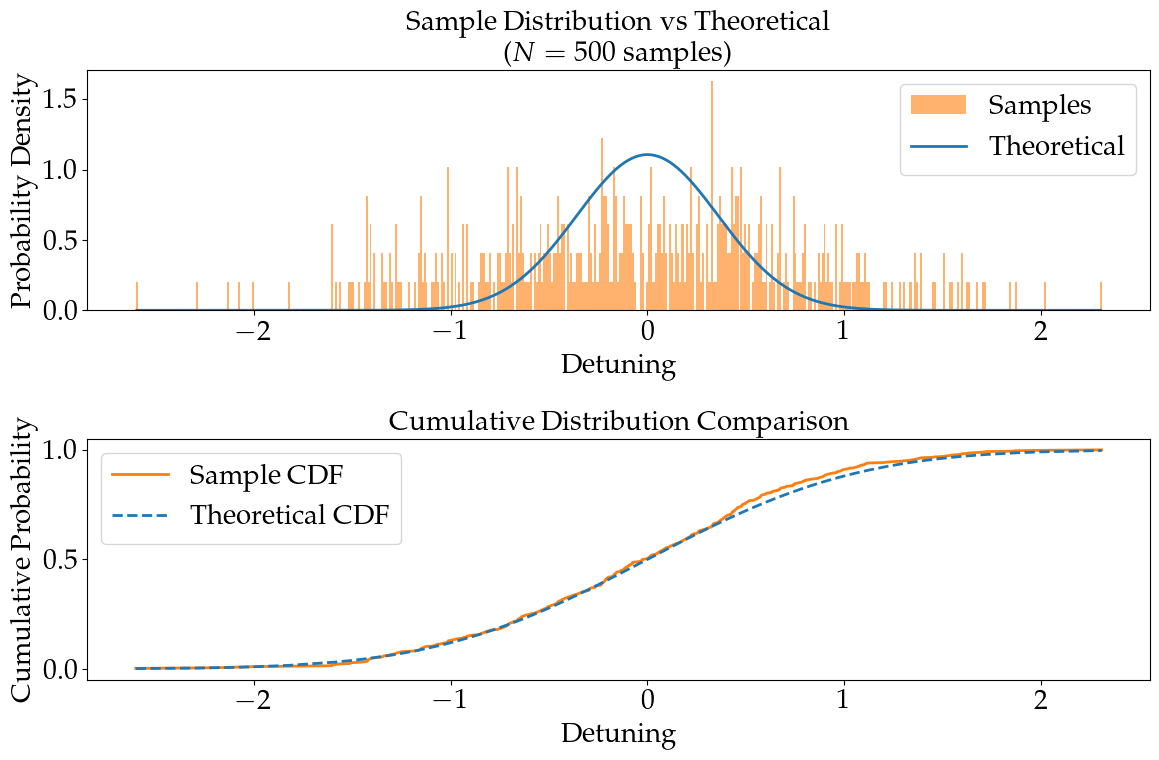

In [2]:
### Test sigma function (normalized Gaussian)
print("Testing sigma function (normalized Gaussian distribution)...")

# Test basic functionality
detunings = np.linspace(-5, 5, 40000)
FWHM_val = 2.0
sigma_val = FWHM_val / (2 * np.sqrt(2 * np.log(2)))  # standard deviation from FWHM

gaussian_vals = normalized_gauss(detunings, FWHM_val, mu=0)

# Test normalization (integral should be approximately 1)
delta_det = detunings[1] - detunings[0]
integral = np.trapz(gaussian_vals, dx=delta_det)
print(f"Gaussian normalization test: integral = {integral:.6f} (should be ≈ 1)")
assert abs(integral - 1.0) < 0.01, f"Gaussian not properly normalized: {integral}"

# Test peak at zero
zero_idx = np.argmin(np.abs(detunings))
print(f"Peak at detuning {detunings[zero_idx]:.6f} with value {gaussian_vals[zero_idx]:.6f}")
peak_val = gaussian_vals[zero_idx]
expected_peak = 1.0 / (sigma_val * np.sqrt(2 * np.pi))
print(f"Peak value test: peak = {peak_val:.6f}, expected = {expected_peak:.6f}")
assert abs(peak_val - expected_peak) < 0.01, "Peak value incorrect"


### Test sample_from_sigma function
print("\nTesting sample_from_sigma function (rejection sampling)...")
n_samples = 500

# Generate samples
samples = sample_from_sigma(n_samples, FWHM_val, mu=0, max_detuning=3.0)

# Test statistical properties
sample_mean = np.mean(samples)
sample_std = np.std(samples)
print(f"Sample statistics: mean = {sample_mean:.6f}, std = {sample_std:.6f}")
print(f"Expected: mean ≈ 0, std ≈ {FWHM_val / (2 * np.sqrt(2 * np.log(2))) :.6f}")

# Mean should be close to zero
assert abs(sample_mean) < 0.1, f"Sample mean too far from zero: {sample_mean}"

# Standard deviation should be close to sigma_val
assert abs(sample_std - FWHM_val / (2 * np.sqrt(2 * np.log(2)))) < 0.2, f"Sample std deviation incorrect: {sample_std}"


### Visualization of sampling results
plt.figure(figsize=(12, 8))

# Plot 2: Sample histogram vs theoretical
plt.subplot(2, 1, 1)
hist_counts, hist_bins, _ = plt.hist(samples, bins=500, density=True, alpha=0.6, 
                                   color='C1', label='Samples')
bin_centers = (hist_bins[:-1] + hist_bins[1:]) / 2
theoretical = normalized_gauss(bin_centers, sigma_val)
plt.plot(bin_centers, theoretical, 'C0', linewidth=2, label='Theoretical')
plt.xlabel(r'Detuning')
plt.ylabel('Probability Density')
plt.title(f'Sample Distribution vs Theoretical\n($N = {n_samples}$ samples)')
plt.legend()

# Plot 3: Cumulative distribution comparison
plt.subplot(2, 1, 2)
sorted_samples = np.sort(samples)
cumulative = np.arange(1, len(sorted_samples) + 1) / len(sorted_samples)
plt.plot(sorted_samples, cumulative, 'C1', label='Sample CDF', linewidth=2)

# Theoretical CDF (using scipy for accuracy)
from scipy.stats import norm
theoretical_cdf = norm.cdf(sorted_samples, 0, sigma_val)
plt.plot(sorted_samples, theoretical_cdf, 'C0--', label='Theoretical CDF', linewidth=2)
plt.xlabel(r'Detuning')
plt.ylabel('Cumulative Probability')
plt.title('Cumulative Distribution Comparison')
plt.legend()

## Test 2: checking all solverS (compute_pulse_evolution)

In [3]:
# =============================
# TEST 2: SOLVER VALIDATION (CHECK_THE_SOLVER)
# =============================

### Test check_the_solver function
print("Testing check_the_solver function...")
solvers = ["BR", "ME", "Paper_BR", "Paper_eqs"]
times = np.linspace(-10, 1000, 201)  # time array: 0 to 100 with dt=0.5
for solver in solvers:
    print(f"Solver: {solver}")
    system_test = SystemParameters(
        ODE_Solver=solver
    )
    res, time_cut = check_the_solver(times, system_test)
    print(f"Time cut: {time_cut}")

Testing check_the_solver function...
Solver: BR
Checking 'BR' solver 


c:\Users\leopo\anaconda3\envs\Master\Lib\site-packages\qutip\utilities.py:53: RuntimeWarning: overflow encountered in exp
  result[non_zero] = 1 / (np.exp(w[non_zero] / w_th) - 1)


Checks passed. Solver appears to be called correctly, and density matrix remains Hermitian and positive.
Time cut: inf
Solver: ME
Checking 'ME' solver 
Checks passed. Solver appears to be called correctly, and density matrix remains Hermitian and positive.
Time cut: inf
Solver: Paper_BR
Checking 'Paper_BR' solver 
Checks passed. Solver appears to be called correctly, and density matrix remains Hermitian and positive.
Time cut: inf
Solver: Paper_eqs
Checking 'Paper_eqs' solver 
Checks passed. Solver appears to be called correctly, and density matrix remains Hermitian and positive.
Time cut: inf


## Test 3: compute_1d_polarization

Testing compute_1d_polarization with parameters:

The times run from -15.00 to 1899.00 with dt = 2.000


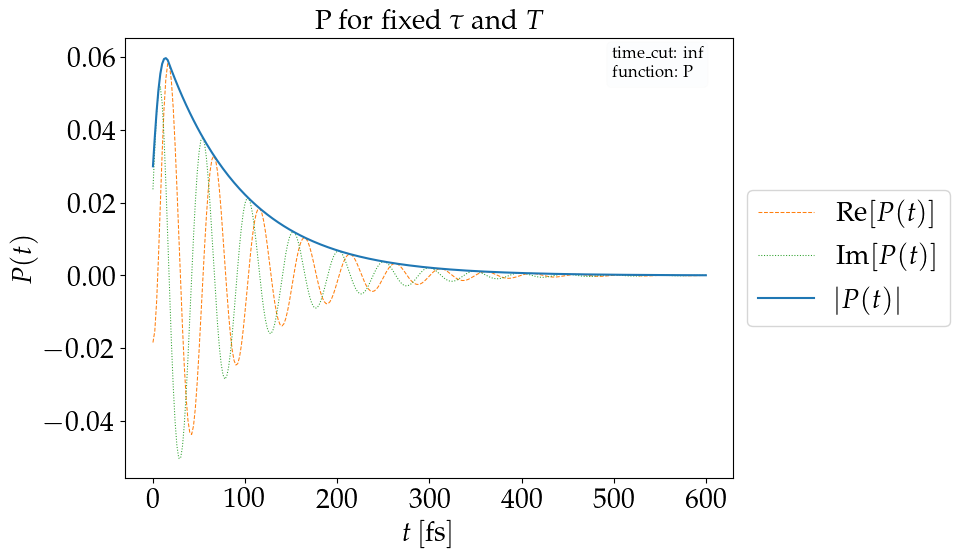

✓ compute_1d_polarization executed successfully.


In [ ]:
# Test compute_1d_polarization for dummy variables

# Define dummy input values
tau_coh_test = 300.0
T_wait_test  = 1000.0
phi_0_test   = 0.0
phi_1_test   = 0.0*np.pi / 2
system_test  = SystemParameters(
    t_max=tau_coh_test + T_wait_test + 600.0,  # Maximum time for simulation
    dt=2,      # Time step
    envelope_type="gaussia  n",  # Use Gaussian pulse envelope
    pulse_FWHM=15.0,
    omega_A_cm=16000.0,
    E0=0.005,
    ODE_Solver="Paper_BR",
    RWA_laser= False,  # Use RWA for laser
)  # Use default parameters
t_max = system_test.t_max  # Maximum time for simulation
# Create time array from -FWHM to t_max with dt
times   = np.arange(-system_test.FWHMs[0], t_max, system_test.dt)  # Time array from 0 to t_max with dt
print(f"Testing compute_1d_polarization with parameters:\n")
print(f"The times run from {times[0]:.2f} to {times[-1]:.2f} with dt = {system_test.dt:.3f}")
time_cut = np.inf
kwargs = {
    "time_cut": time_cut,  # to avoid numerical issues
#    "tau_coh": tau_coh_test,
#    "T_wait": T_wait_test,
    "function": "P" # Polarization function 
}

try:
    result = compute_1d_polarization(
        tau_coh=tau_coh_test,
        T_wait=T_wait_test,
        phi_0=phi_0_test,
        phi_1=phi_1_test,
        times=times,
        system=system_test,
        **kwargs
    )
    # Plot the data for a fixed tau_coh and T_wait
    Plot_fixed_tau_T(
        result[0], result[1], **kwargs
    )
    print("✓ compute_1d_polarization executed successfully.")
except Exception as e:
    print("❌ compute_1d_polarization failed:", e)

Plot not saved. Ensure 'save' is True and 'output_dir' is specified.


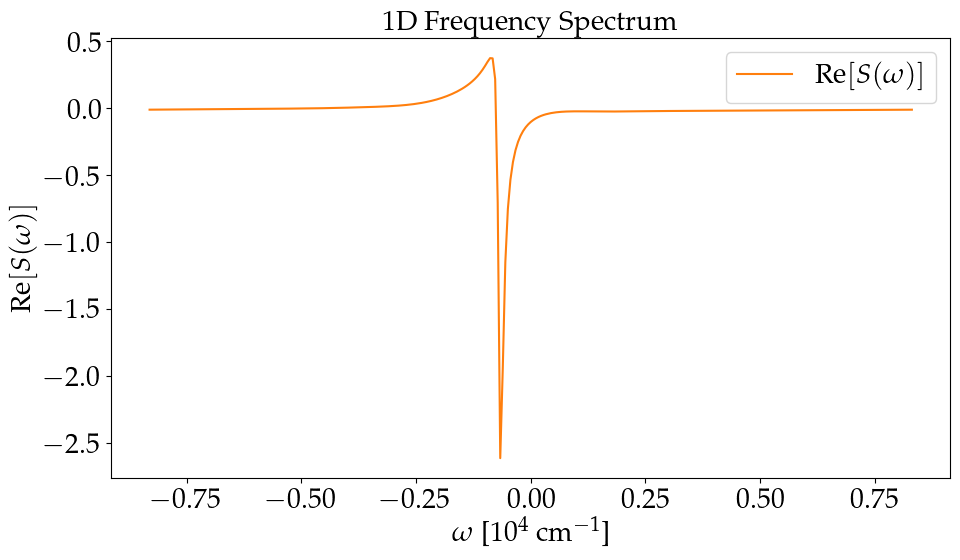

In [22]:
t_freqs, data_freqs = compute_1d_fft_wavenumber(
    result[0], result[1])

Plot_1d_frequency_spectrum(
    t_freqs, data_freqs,
    type="real")

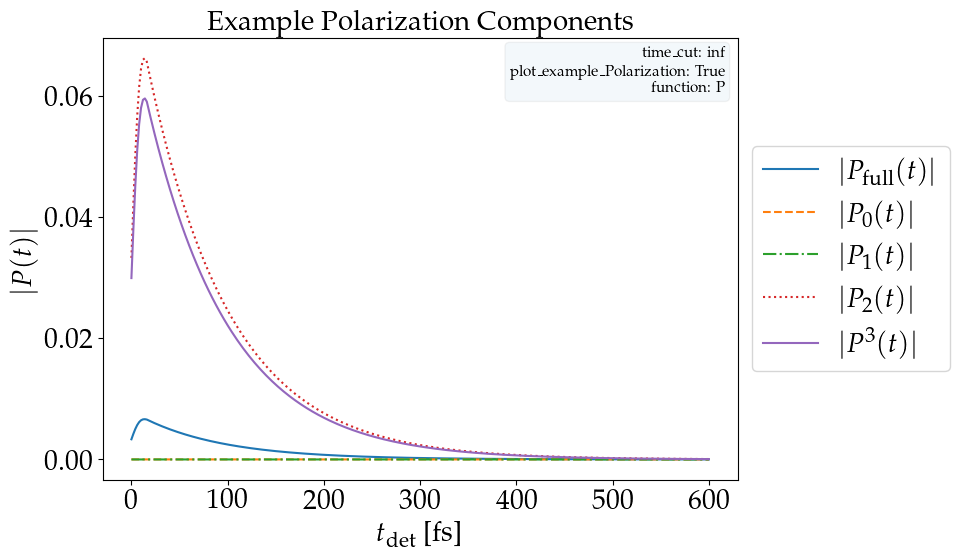

✓ compute_1d_polarization executed successfully.


In [23]:
# Test compute_1d_polarization for dummy variables
kwargs = {
    "time_cut": time_cut,  # to avoid numerical issues
#    "tau_coh": tau_coh_test,
#    "T_wait": T_wait_test,
    "plot_example_Polarization": True,  # Enable example polarization plot
    "function": "P" # Polarization function 
}

try:
    times_plot, P_full, P_only0, P_only1, P_only2 = compute_1d_polarization(
        tau_coh=tau_coh_test,
        T_wait=T_wait_test,
        phi_0=phi_0_test,
        phi_1=phi_1_test,
        times=times,
        system=system_test,
        **kwargs  # Unpack the kwargs dictionary with **
    )
    # Plot the data for a fixed tau_coh and T_wait
    Plot_example_Polarization(
        times_plot, P_full, P_only0, P_only1, P_only2, **kwargs  # Unpack kwargs here too
    )
    print("✓ compute_1d_polarization executed successfully.")
except Exception as e:
    print("❌ compute_1d_polarization failed:", e)


Setting up test parameters...


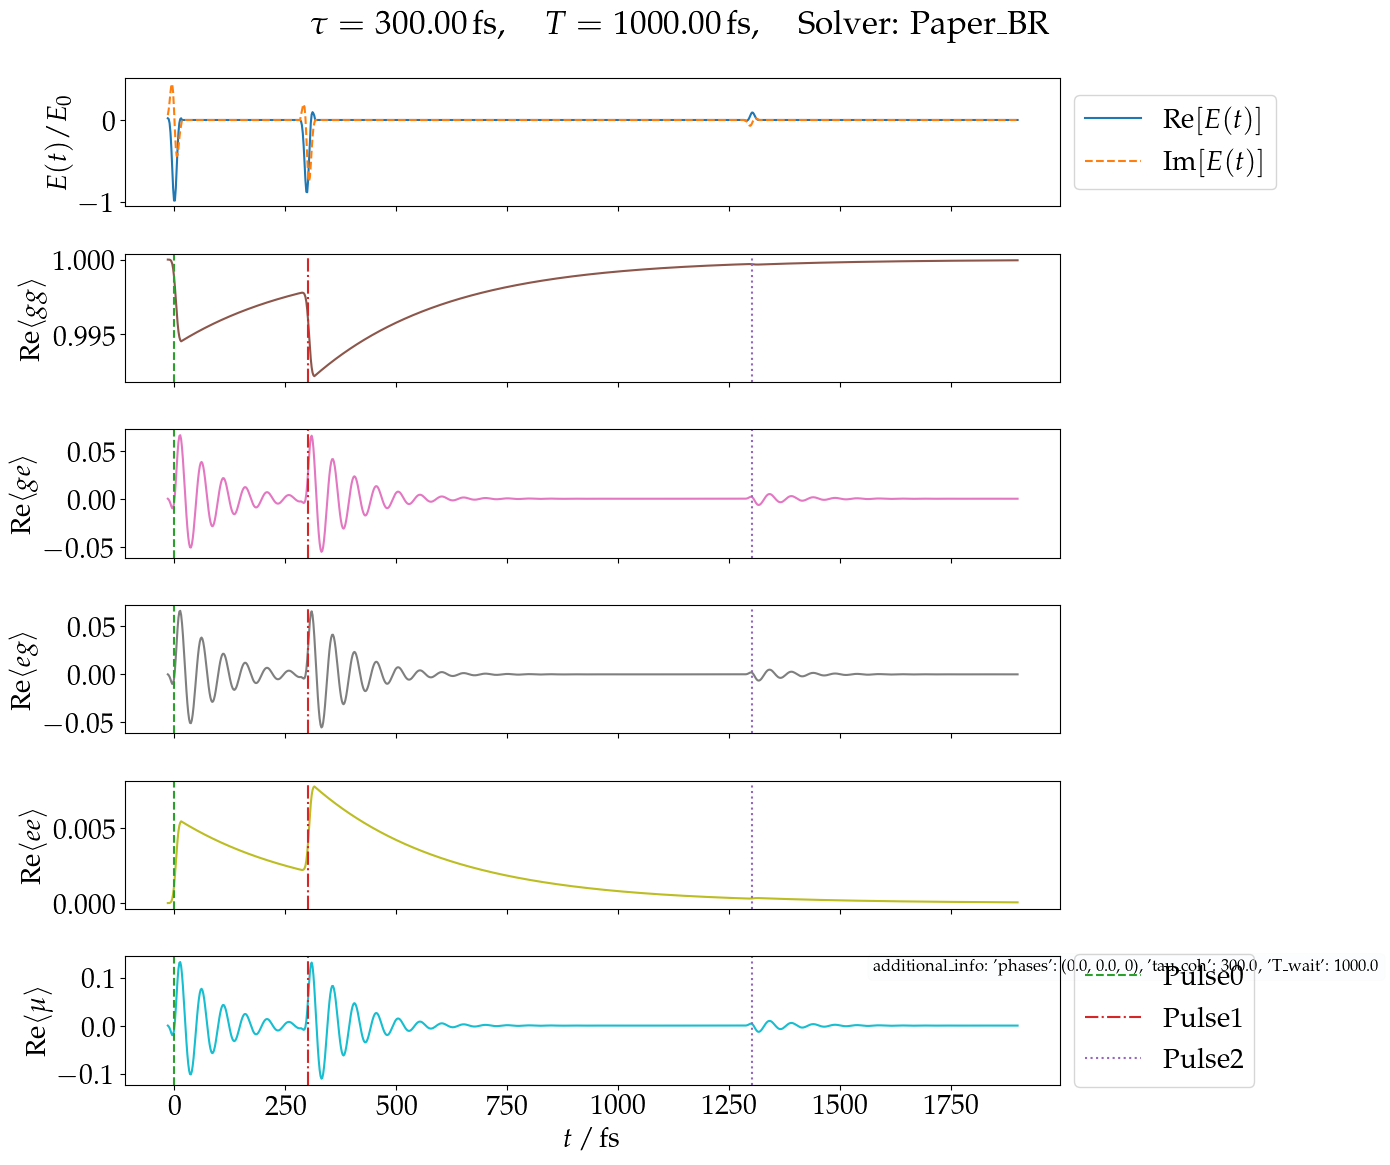

Example evolution plot created successfully.


In [24]:
### Create test system and time arrays
print("\nSetting up test parameters...")

# Plot an example evolution:
kwargs = {
    "plot_example": True,
    "time_cut": time_cut,
}

try:
    res = compute_1d_polarization(
        tau_coh=tau_coh_test,
        T_wait=T_wait_test,
        phi_0=phi_0_test,
        phi_1=phi_1_test,
        times=times,
        system=system_test,
        **kwargs  # Unpack the kwargs dictionary with **
    )
    times_plot, data_expectations, pulse_seq_f, additional_info = res[:]

    Plot_example_evo(times_plot, data_expectations, pulse_seq_f, tau_coh=tau_coh_test, T_wait=T_wait_test, system=system_test, additional_info=additional_info)
    print(f"Example evolution plot created successfully.")
except Exception as e:
    print(f"Error during compute_2d_polarization: {e}")


Processing 10 frequencies with 4×4 phase combinations
Using 12 parallel workers for phase combinations

Processing frequency 1/10: ω_A = 16030.41 cm⁻¹
  Completed 4/16 phase combinations
  Completed 8/16 phase combinations
  Completed 12/16 phase combinations
  Completed 16/16 phase combinations
  Performing IFT for frequency 1/10...
  ✅ IFT completed for frequency 1

Processing frequency 2/10: ω_A = 16015.03 cm⁻¹
  Completed 4/16 phase combinations
  Completed 8/16 phase combinations
  Completed 12/16 phase combinations
  Completed 16/16 phase combinations
  Performing IFT for frequency 2/10...
  ✅ IFT completed for frequency 2

Processing frequency 3/10: ω_A = 15908.78 cm⁻¹
  Completed 4/16 phase combinations
  Completed 8/16 phase combinations
  Completed 12/16 phase combinations
  Completed 16/16 phase combinations
  Performing IFT for frequency 3/10...
  ✅ IFT completed for frequency 3

Processing frequency 4/10: ω_A = 15964.00 cm⁻¹
  Completed 4/16 phase combinations
  Completed 

RuntimeError: latex was not able to process the following string:
b'$E_k_s(t)$'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmp29ybyodf 41bcfbf77af907a7836a94857fd1ca0e.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.26 (MiKTeX 24.4) (preloaded format=latex.fmt)
 restricted \write18 enabled.
entering extended mode
(41bcfbf77af907a7836a94857fd1ca0e.tex
LaTeX2e <2024-06-01> patch level 2
L3 programming layer <2024-08-30>
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/base\article.cls
Document Class: article 2024/02/08 v1.4n Standard LaTeX document class
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/base\size10.clo))
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/psnfss\mathpazo.sty)
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/type1cm\type1cm.sty)
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/cm-super\type1ec.sty
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/base\t1cmr.fd))
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/base\inputenc.sty)
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/geometry\geometry.sty
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/graphics\keyval.sty)
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/generic/iftex\ifvtex.sty
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/generic/iftex\iftex.sty))
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/geometry\geometry.cfg))
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/amsmath\amsmath.sty
For additional information on amsmath, use the `?' option.
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/amsmath\amstext.sty
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/amsmath\amsgen.sty))
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/amsmath\amsbsy.sty)
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/amsmath\amsopn.sty))
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/underscore\underscore.s
ty)
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/firstaid\underscore-ltx
.sty) (C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/base\textcomp.sty
) (C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/psnfss\ot1ppl.fd)
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/l3backend\l3backend-dvi
ps.def)
No file 41bcfbf77af907a7836a94857fd1ca0e.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/psnfss\omlzplm.fd)
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/psnfss\omszplm.fd)
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/psnfss\omxzplm.fd)
(C:\Users\leopo\AppData\Local\Programs\MiKTeX\tex/latex/psnfss\ot1zplm.fd)
! Double subscript.
_... \ifx \protect \@typeset@protect \ifmmode \sb 
                                                  \else \BreakableUnderscore...
l.30 {\rmfamily $E_k_
                     s(t)$}%
No pages of output.
Transcript written on C:\Users\leopo\.matplotlib\tex.cache\41\bc\tmp29ybyodf\41
bcfbf77af907a7836a94857fd1ca0e.log.




<Figure size 1000x600 with 1 Axes>

✓ compute_1d_polarization executed successfully.
Plot not saved. Ensure 'save' is True and 'output_dir' is specified.


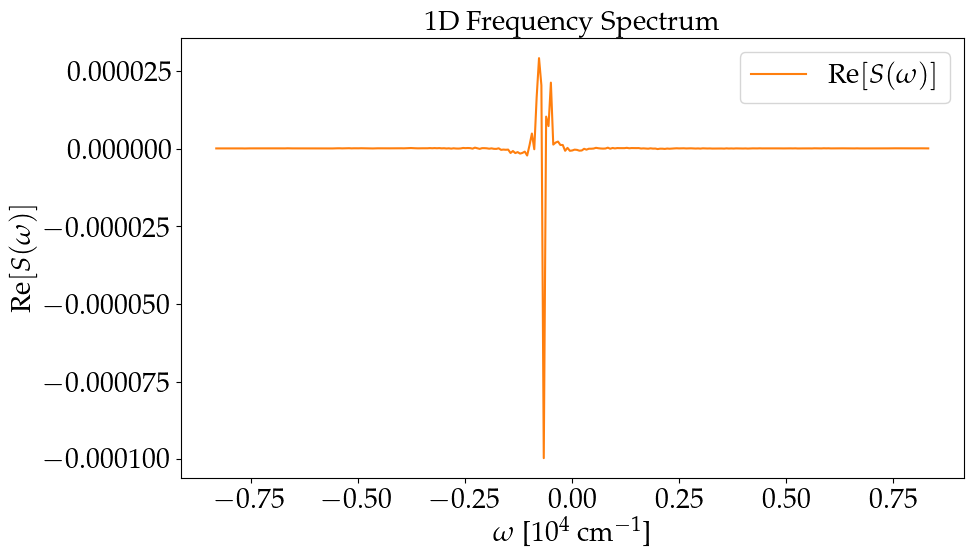

In [ ]:
kwargs = {
    "time_cut": time_cut,  # to avoid numerical issues
#    "tau_coh": tau_coh_test,
#    "T_wait": T_wait_test,
    "function": "E_{ks}"  # Electric field function
}

try:
    result = parallel_compute_1d_E_with_inhomogenity(10, 4, tau_coh_test, T_wait_test, times, system_test, **kwargs)
    # Plot the data for a fixed tau_coh and T_wait
    Plot_fixed_tau_T(
        result[0], result[1], **kwargs
    )
    print("✓ compute_1d_polarization executed successfully.")
except Exception as e:
    print("❌ compute_1d_polarization failed:", e)

t_freqs, data_freqs = compute_1d_fft_wavenumber(
    result[0], result[1])

Plot_1d_frequency_spectrum(
    t_freqs, data_freqs,
    type="real")

## Test 4: get_tau_cohs_and_t_dets_for_T_wait

In [9]:
    # =============================
# TEST 1: TIME ARRAY CALCULATIONS
# =============================

### Test get_tau_cohs_and_t_dets_for_T_wait function
print("Testing get_tau_cohs_and_t_dets_for_T_wait function...")

# Test basic functionality with reasonable parameters
times = np.linspace(-2, 100, 201)  # time array: 0 to 100 with dt=0.5
T_wait = 50.0  # waiting time

tau_cohs, t_dets = get_tau_cohs_and_t_dets_for_T_wait(times, T_wait)

print(f"Generated time arrays:")
print(
    f"  Input times: {len(times)} points, range [{times[0]:.2f}, {times[-1]:.2f}], dt = {times[1]-times[0]:.3f}"
)
print(f"  T_wait = {T_wait}")
print(
    f"  tau_cohs: {len(tau_cohs)} points, range [{tau_cohs[0]:.2f}, {tau_cohs[-1]:.2f}]"
)
print(f"  t_dets: {len(t_dets)} points, range [{t_dets[0]:.2f}, {t_dets[-1]:.2f}]")

# Test array properties
assert len(tau_cohs) > 0, "tau_cohs array is empty"
assert len(t_dets) > 0, "t_dets array is empty"
assert len(tau_cohs) == len(t_dets), "tau_cohs and t_dets should have same length"
assert tau_cohs[0] >= 0, "tau_cohs should start from non-negative value"
assert t_dets[0] >= 0, "t_dets should start from non-negative value"
assert (
    t_dets[-1] <= times[-1]
), f"t_dets exceeds maximum time: {t_dets[-1]} > {times[-1]}"


# Test with T_wait = t_max (edge case)
print("\nTesting T_wait = t_max (edge case):")
T_wait_max = times[-1]
tau_edge, t_det_edge = get_tau_cohs_and_t_dets_for_T_wait(times, T_wait_max)
print(
    f"  T_wait = t_max = {T_wait_max}: tau_cohs length = {len(tau_edge)}, t_dets length = {len(t_det_edge)}"
)
if len(tau_edge) > 0:
    print(f"    Values: tau_coh = {tau_edge}, t_det = {t_det_edge}")

# Test with T_wait > t_max (should return empty arrays)
print("\nTesting T_wait > t_max (should return empty):")
T_wait_large = times[-1] + 10.0
tau_empty, t_det_empty = get_tau_cohs_and_t_dets_for_T_wait(times, T_wait_large)
print(
    f"  T_wait = {T_wait_large} > t_max = {times[-1]}: tau_cohs length = {len(tau_empty)}, t_dets length = {len(t_det_empty)}"
)
assert len(tau_empty) == 0, "Should return empty array when T_wait > t_max"
assert len(t_det_empty) == 0, "Should return empty array when T_wait > t_max"

### Test with single time point
print("\nTesting single time point:")
times_single = np.array([0.0])
tau_single, t_det_single = get_tau_cohs_and_t_dets_for_T_wait(times_single, 0.0)
print(f"  Single time point: tau_cohs = {tau_single}, t_dets = {t_det_single}")

### Visualization of time arrays
print("\nCreating visualizations...")
plt.figure(figsize=(14, 10))

### Plot 1: Time arrays for different T_wait values
plt.subplot(2, 3, 1)
T_wait_vis = [-10.0, 10.0, 25.0, 40.0, 60.0, 80.0]
colors = plt.cm.viridis(np.linspace(0, 1, len(T_wait_vis)))

for i, T_w in enumerate(T_wait_vis):
    tau_vis, t_det_vis = get_tau_cohs_and_t_dets_for_T_wait(times, T_w)
    if len(tau_vis) > 0:
        plt.plot(
            tau_vis,
            np.full_like(tau_vis, i),
            "o",
            color=colors[i],
            markersize=2,
            label=rf"$\tau_{{\text{{coh}}}}$ ($T_{{\text{{wait}}}}={T_w}$)",
            alpha=0.7,
        )
        plt.plot(
            t_det_vis,
            np.full_like(t_det_vis, i + 0.1),
            "s",
            color=colors[i],
            markersize=2,
            alpha=0.7,
            label=rf"$t_{{\text{{det}}}}$ ($T_{{\text{{wait}}}}={T_w}$)",
        )
plt.xlabel(r"Time $t$")
plt.ylabel(r"$T_{\text{wait}}$ Value Index")
plt.title(r"Time Arrays for Different $T_{\text{wait}}$ Values")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8)
plt.grid(True, alpha=0.3)

### Plot 2: Array length vs T_wait
plt.subplot(2, 3, 2)
T_wait_range = np.linspace(5, 95, 50)
array_lengths = []

for T_w in T_wait_range:
    tau_test, t_det_test = get_tau_cohs_and_t_dets_for_T_wait(times, T_w)
    array_lengths.append(len(tau_test))

plt.plot(T_wait_range, array_lengths, "C0o-", markersize=3)
plt.xlabel(r"$T_{\text{wait}}$")
plt.ylabel(r"Array Length")
plt.title(r"Array Length vs $T_{\text{wait}}$")
plt.grid(True, alpha=0.3)

### Plot 3: Time coverage analysis
plt.subplot(2, 3, 3)
tau_coverage = []
t_det_coverage = []

for T_w in T_wait_range:
    tau_test, t_det_test = get_tau_cohs_and_t_dets_for_T_wait(times, T_w)
    tau_max = tau_test[-1] if len(tau_test) > 0 else 0
    t_det_max = t_det_test[-1] if len(t_det_test) > 0 else 0
    tau_coverage.append(tau_max)
    t_det_coverage.append(t_det_max)

plt.plot(T_wait_range, tau_coverage, "C0o-", label=r"Max $\tau_{\text{coh}}$", markersize=3)
plt.plot(T_wait_range, t_det_coverage, "C1s-", label=r"Max $t_{\text{det}}$", markersize=3)
plt.plot(
    T_wait_range, 
    times[-1] - T_wait_range, 
    "k--", 
    alpha=0.5, 
    label=r"Expected max $\tau_{\text{coh}}$"
)
plt.plot(
    T_wait_range, 
    np.full_like(T_wait_range, times[-1]), 
    "r--", 
    alpha=0.5, 
    label=r"$t_{\text{max}}$"
)
plt.xlabel(r"$T_{\text{wait}}$")
plt.ylabel(r"Time")
plt.title(r"Time Coverage Analysis")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ All time array calculation tests passed!")


IndentationError: expected an indented block after 'if' statement on line 42 (4032299242.py, line 43)

## Test 5: compute_2d_polarization

In [ ]:
### Test compute_2d_polarization function
print("Testing compute_2d_polarization function...")

### Create test system and time arrays
print("\nSetting up test parameters...")
system_test = SystemParameters(
    t_max=10.0,  # Maximum time for simulation
    dt=0.1,      # Time step
    envelope_type='gaussian',  # Envelope type for pulses
)
t_max = system_test.t_max
times = np.arange(-system_test.FWHMs[0], t_max, system_test.dt)  # Dense time array for accurate calculation

# Test parameters for 2DES simulation
phi_0 = 0.0             # Phase of first pulse
phi_1 = np.pi/4         # Phase of second pulse
T_wait = t_max/2        # Waiting time between pulses
time_cut = np.inf       # No time cut for this test

print(f"System parameters:")
print(f"  Time array: {len(times)} points, dt = {times[1]-times[0]:.3f}")

### Test T_wait near time limits
print("\nTesting T_wait near time limits:")

T_wait_edge_cases = [t_max/2]# [0, t_max/2, t_max]
for T_w in T_wait_edge_cases:
    try:
        t_det, tau_coh, data = compute_2d_polarization(
            T_wait=T_w, phi_0=phi_0, phi_1=phi_1, times=times, system=system_test, time_cut=time_cut
        )
        Plot_polarization_2d_spectrum((t_det, tau_coh, data), use_custom_colormap=True)
        print(f"  T_wait={T_w:5.1f} ({T_w/t_max:.1%} of t_max): ✓ Success, shape {data.shape}")
    except Exception as e:
        print(f"  T_wait={T_w:5.1f}: ❌ Failed - {e}")

    
### Test with time_cut parameter
print("\nTesting time_cut parameter:")
time_cuts = []# [np.inf, t_max/2, t_max]
for tc in time_cuts:
    try:
        t_det, tau_coh, data = compute_2d_polarization(
            T_wait=T_wait, phi_0=phi_0, phi_1=phi_1, times=times, system=system_test, time_cut=tc
        )
        Plot_polarization_2d_spectrum((t_det, tau_coh, data), use_custom_colormap=True)

        effective_max_time = np.max(tau_coh) + T_wait + np.max(t_det)
        print(f"  time_cut={tc:5.1f}: ✓ Success, effective_max_time={effective_max_time:.1f}")
    except Exception as e:
        print(f"  time_cut={tc:5.1f}: ❌ Failed - {e}")
        


In [ ]:
### Create test system and time arrays
print("\nSetting up test parameters...")
system_test = SystemParameters(
    t_max=10.0,  # Maximum time for simulation
    dt=0.1,      # Time step
    envelope_type='gaussian',  # Envelope type for pulses
    pulse_FWHM=10.0,  # Pulse FWHM
)
t_max = system_test.t_max
times = np.arange(-system_test.FWHMs[0], t_max, system_test.dt)  # Dense time array for accurate calculation

# Plot an example evolution:
tau_coh_ex = t_max / 3
kwargs = {
    "plot_example": True,
    "plot_example_for_tau": tau_coh_ex,
}

try:
    res = compute_2d_polarization(
        T_wait=T_wait, phi_0=phi_0, phi_1=phi_1, times=times, system=system_test, time_cut=time_cut, **kwargs
    )
    times_plot, data_expectations, pulse_seq_f, additional_info = res[:]

    Plot_example_evo(times_plot, data_expectations, pulse_seq_f, tau_coh_ex, T_wait=T_wait, system=system_test)
    print(f"Example evolution plot created successfully.")
except Exception as e:
    print(f"Error during compute_2d_polarization: {e}")


In [ ]:
### Create test system and time arrays
print("\nSetting up test parameters...")
system_test = SystemParameters(
    t_max=100.0,  # Maximum time for simulation
    dt=0.1,      # Time step
    envelope_type='gaussian',  # Envelope type for pulses
    pulse_FWHM=10.0,  # Pulse FWHM
)

n_freqs = 1
n_phases = 3
t_max = system_test.t_max
times = np.arange(-system_test.FWHMs[0], t_max, system_test.dt)  # Dense time array for accurate calculation

plot_args = {
    "domain": "freq",
    "type": "real",
    "save": False,
    #"use_custom_colormap": True,
    # "section": (1, 2, 1, 2),  # Plot the first section
    #"system": system_test,
}

try:
    from src.spectroscopy.calculations import parallel_compute_2d_E_with_inhomogenity
    data_list = parallel_compute_2d_E_with_inhomogenity(
        n_freqs=n_freqs, n_phases=n_phases, times_T=[T_wait], times=times, system=system_test
    )
    
    extend_and_plot_results(data_list, times_T=[T_wait], times=times, extend_for=(1,1), **plot_args)

except Exception as e:
    print(f"Error during compute_2d_polarization: {e}")


In [ ]:
plot_args = {
    "domain": "freq",
    "type": "imag",
    "save": False,
    #"use_custom_colormap": True,
    "section": (1.5, 1.8, 1.5, 1.8),  # Plot the first section
    #"system": system_test,
}
extend_and_plot_results(data_list, times_T=[T_wait], times=times, extend_for=(1,2), **plot_args)


In [ ]:
# =============================
# TEST 4: PHYSICS VALIDATION
# =============================

print("\n--- TEST 4: Physics validation ---")
### Test phase dependence (should show different signals for different phases)
print("\nTesting phase dependence:")
try:
    # Compare in-phase vs out-of-phase signals
    _, _, data_in_phase = compute_2d_polarization(
        T_wait=5.0, phi_0=0, phi_1=0, times=times[:101], system=system_test, time_cut=20.0
    )
    _, _, data_out_phase = compute_2d_polarization(
        T_wait=5.0, phi_0=0, phi_1=np.pi, times=times[:101], system=system_test, time_cut=20.0
    )
    
    rms_in = np.sqrt(np.mean(data_in_phase**2))
    rms_out = np.sqrt(np.mean(data_out_phase**2))
    phase_difference = np.sqrt(np.mean((data_in_phase - data_out_phase)**2))
    
    print(f"  In-phase RMS: {rms_in:.2e}")
    print(f"  Out-phase RMS: {rms_out:.2e}")
    print(f"  Phase difference RMS: {phase_difference:.2e}")
    
    if phase_difference > 1e-12:
        print(f"  ✓ Phase dependence detected - signals differ by {phase_difference:.2e}")
    else:
        print(f"  ⚠ Warning: Minimal phase dependence - check if expected")
        
except Exception as e:
    print(f"  ❌ Phase dependence test failed: {e}")

### Test T_wait dependence
print("\nTesting T_wait dependence:")
try:
    T_waits = [2.0, 8.0]
    data_short = compute_2d_polarization(
        T_wait=T_waits[0], phi_0=0, phi_1=0, times=times[:101], system=system_test, time_cut=15.0
    )[2]
    data_long = compute_2d_polarization(
        T_wait=T_waits[1], phi_0=0, phi_1=0, times=times[:101], system=system_test, time_cut=25.0
    )[2]

    # Compare signal magnitudes (should decay with longer T_wait due to relaxation)
    rms_short = np.sqrt(np.mean(data_short**2))
    rms_long = np.sqrt(np.mean(data_long**2))
    
    print(f"  T_wait={T_waits[0]}: RMS={rms_short:.2e}")
    print(f"  T_wait={T_waits[1]}: RMS={rms_long:.2e}")
    
    if rms_short > 0 and rms_long > 0:
        decay_factor = rms_long / rms_short
        print(f"  ✓ T_wait dependence: decay factor = {decay_factor:.3f}")
        if decay_factor < 1.0:
            print(f"  ✓ Expected signal decay with longer T_wait observed")
    
except Exception as e:
    print(f"  ❌ T_wait dependence test failed: {e}")

## Test 6: compute_2d_fft_wavenumber Function

This section tests the `compute_2d_fft_wavenumber` function with a 2D Gaussian to understand the shape mismatch issue that causes the IndexError.

In [ ]:
# =============================
# TEST 2D FFT FUNCTION WITH GAUSSIAN
# =============================

### Create test data: 2D Gaussian
N_t, N_tau = 5, 5
ts = np.linspace(0, 100, N_t)        # 0-100 fs
taus = np.linspace(0, 80, N_tau)     # 0-80 fs

# Create 2D Gaussian centered at (40 fs, 60 fs)
tau_center, t_center = 40, 60
sigma_tau, sigma_t = 10, 15

# Create meshgrid for 2D Gaussian
TAU, T = np.meshgrid(taus, ts, indexing='ij')  # Shape: (N_tau, N_t)
gaussian_2d = np.exp(-((TAU - tau_center)**2 / (2 * sigma_tau**2) + 
                       (T - t_center)**2 / (2 * sigma_t**2)))

print(f"Input data shapes:")
print(f"  ts: {ts.shape}")
print(f"  taus: {taus.shape}")
print(f"  gaussian_2d: {gaussian_2d.shape}")
print(f"  Expected: taus along axis 0, ts along axis 1")

In [ ]:
### Test the compute_2d_fft_wavenumber function
nu_ts, nu_taus, data_freq = compute_2d_fft_wavenumber(ts, taus, gaussian_2d)

print(f"\nOutput shapes from compute_2d_fft_wavenumber:")
print(f"  nu_ts: {nu_ts.shape}")
print(f"  nu_taus: {nu_taus.shape}")
print(f"  data_freq: {data_freq.shape}")
print(f"  data_freq dtype: {data_freq.dtype}")

### Analyze the shape reduction
print(f"\nShape analysis:")
print(f"  Input:  ts({N_t}) × taus({N_tau}) → data({N_tau}, {N_t})")
print(f"  Output: nu_ts({len(nu_ts)}) × nu_taus({len(nu_taus)}) → data_freq{data_freq.shape}")
print(f"  Reduction: {N_t}→{len(nu_ts)} (factor: {N_t//len(nu_ts) if len(nu_ts) > 0 else 'N/A'})")
print(f"             {N_tau}→{len(nu_taus)} (factor: {N_tau//len(nu_taus) if len(nu_taus) > 0 else 'N/A'})")

In [ ]:
### Visualize the shape mismatch problem
plt.figure(figsize=(16, 8))

### Plot original 2D Gaussian
plt.subplot(2, 3, 1)
plt.imshow(gaussian_2d, aspect='auto', origin='lower', 
           extent=[ts[0], ts[-1], taus[0], taus[-1]])
plt.colorbar(label='Amplitude')
plt.xlabel(r'$t$ (fs)')
plt.ylabel(r'$\tau$ (fs)')
plt.title(f'Original 2D Gaussian\nShape: {gaussian_2d.shape}')

### Plot FFT magnitude
plt.subplot(2, 3, 2)
plt.imshow(np.abs(data_freq), aspect='auto', origin='lower',
           extent=[nu_ts[0], nu_ts[-1], nu_taus[0], nu_taus[-1]])
plt.colorbar(label='|FFT|')
plt.xlabel(r'$\nu_t$ ($10^4$ cm$^{-1}$)')
plt.ylabel(r'$\nu_{\tau}$ ($10^4$ cm$^{-1}$)')
plt.title(f'FFT Magnitude\nShape: {data_freq.shape}')


plt.tight_layout()
plt.show()

## Test 7: extend_and_plot_results Function

This test creates synthetic 2D spectroscopy data to verify the `extend_and_plot_results` function works correctly and understand its data structure requirements.

In [ ]:
# =============================
# TEST: extend_and_plot_results Function
# =============================
print("\n" + "="*80)
print("TESTING extend_and_plot_results FUNCTION")
print("="*80)

### Create test system parameters
test_system = SystemParameters(
    N_atoms=1,
    ODE_Solver="Paper_eqs",
    RWA_laser=True,
    t_max=100.0,
    dt=0.5,
    Delta_cm=200.0,  # inhomogeneous broadening
    omega_A_cm=16000.0,
    envelope_type='gaussian',
    pulse_FWHM=10.0
)

### Create time arrays
times = np.arange(-test_system.FWHMs[0], test_system.t_max, test_system.dt)
print(f"Time grid: {len(times)} points from {times[0]:.1f} to {times[-1]:.1f} fs")

### Define multiple T_wait values to test
times_T = np.array([10.0]) #, 30.0, 50.0
print(f"Testing with T_wait values: {times_T}")

### Generate synthetic 2D data for each T_wait
averaged_results = []

for i, T_wait in enumerate(times_T):
    # Get tau and t arrays for this T_wait
    tau_coh_vals, t_det_vals = get_tau_cohs_and_t_dets_for_T_wait(times, T_wait)
    
    if len(tau_coh_vals) == 0 or len(t_det_vals) == 0:
        print(f"  T_wait={T_wait}: No valid time points, skipping")
        averaged_results.append(None)
        continue
        
    print(f"  T_wait={T_wait}: tau_coh={len(tau_coh_vals)} points, t_det={len(t_det_vals)} points")
    
    ### Create synthetic 2D data with realistic structure
    # Data shape should be (N_taus, N_ts) according to the function expectation
    data_shape = (len(tau_coh_vals), len(t_det_vals))
    
    # Create synthetic data with some physical-like features
    tau_mesh, t_mesh = np.meshgrid(tau_coh_vals, t_det_vals, indexing='ij')
    
    # Synthetic 2D spectrum with exponential decay and oscillations
    synthetic_data = (
        np.exp(-tau_mesh / 20.0) *  # coherence decay
        np.exp(-t_mesh / 30.0) *    # population decay  
        np.cos(2 * np.pi * tau_mesh / 6.0) *  # oscillations in tau
        np.sin(2 * np.pi * t_mesh / 10.0)    # oscillations in t
        *(2.0 + 0.1 * np.random.randn(*data_shape))  # small noise
    )
    
    # Add some peak features
    peak_tau_idx = len(tau_coh_vals) // 3
    peak_t_idx = len(t_det_vals) // 3
    synthetic_data[peak_tau_idx-2:peak_tau_idx+3, peak_t_idx-2:peak_t_idx+3] += 0.5
    
    averaged_results.append(synthetic_data.astype(np.float32))
    
    print(f"    Created synthetic data with shape: {synthetic_data.shape}")
    print(f"    Data range: [{synthetic_data.min():.3f}, {synthetic_data.max():.3f}]")

print(f"\nGenerated {len([r for r in averaged_results if r is not None])} valid datasets")

In [ ]:
### Test the extend_and_plot_results function
print("\n" + "-"*60)
print("TESTING extend_and_plot_results function...")
print("-"*60)

### Set up plotting arguments
plot_args_freq = {
    "domain": "freq",
    "type": "real",  # Test with real part
    "save": False,   # Don't save during testing
    "output_dir": None,
    "use_custom_colormap": True,
    "system": test_system,
}

### Test 1: Basic functionality without extension
print("\n1. Testing basic functionality (no extension):")
try:
    extend_and_plot_results(
        averaged_results=averaged_results,
        times_T=times_T,
        times=times,
        extend_for=None,  # No extension
        **plot_args_freq
    )
    print("   ✓ Basic functionality test PASSED")
except Exception as e:
    print(f"   ❌ Basic functionality test FAILED: {e}")
    import traceback
    traceback.print_exc()